In [1]:
import sys

from tqdm import tqdm
import execution_limiter

sys.path.append("../")
from calculus_path_mod.term_engine import *
from calculus_path_mod.reduction_strategy import *
from calculus_path_mod.terms import num_comparison, nat_numbers, arithm_ops, combinators, pairs, logic
from calculus_path_mod.terms.pseudonym import *

from calculus_path_mod.json_serialization import load_terms
from fitter import Fitter, get_common_distributions
from calculus_utils.drawing import draw_steps_displot

In [6]:
def normalize_term_time_limit(term, strategy):
    result = np.inf
    try:
        with execution_limiter.execution_time_limiter(60, 'term normalization'):
            result = term.normalize(strategy)[1]
    except execution_limiter.TimeoutException:
        pass

    return result


def get_expected_steps(steps):
    steps = list(filter(lambda x: x != float("inf"), steps))
    steps = list(filter(lambda x: x != 0, steps))

    distributions = get_common_distributions()
    distributions.remove("expon")
    f_ln = Fitter([np.log(step) for step in steps], distributions=distributions)
    f_ln.fit()

    mu, sigma = f_ln.fitted_param["norm"]
    result = np.e ** (mu + (sigma ** 2) / 2)
    return result

In [3]:
REDEX_TYPE = {
    "none": "none",
    "named": "NAMED-REDEX",
    "var": "VAR-REDEX",
}

class CallByNameStrategy(OneStepStrategy):
    def _get_redexes_indexes(self, term: Term, init_index: int = 0, path_depth: int = 0) -> dict:
        """
        Using Left Outer strategy find all redexes, it's coordinates in the term tree,
        and the depth value for each redex.

        :param term: some Term is a current vertex
        :param init_index: some index is a coordinate of the current vertex in the term tree
        :param path_depth: depth in the term tree (simply recursion layer).
        :return: dict where a key is a index (coordinate of redex in the term tree),
                 and var is a depth from the tree root
        """

        if (term.kind == "atom") or (len(term.redexes) == 0):
            raise ValueError("The term doesn't contain a redex")
        if term.kind == "application":
            result = dict()
            if term.is_beta_redex:
                result = {**result,
                          **{init_index + 1: path_depth + 1}}
            if len(term._data[0].redexes) != 0:
                result = {**result,
                          **self._get_redexes_indexes(term._data[0], init_index + 1, path_depth + 1)}
            if len(term._data[1].redexes) != 0:
                result = {**result,
                          **self._get_redexes_indexes(term._data[1],
                                                      init_index + term._data[0].vertices_number + 1,
                                                      path_depth + 1)}
            return result
            # self is Abstraction:
        return self._get_redexes_indexes(term._data[1], init_index + 1, path_depth + 1)

    def _get_colored_redexes(self, term: Term) -> dict:
        dict_redexes_indexes = self._get_redexes_indexes(term)
        dict_result = dict()
        for key_, item_ in dict_redexes_indexes.items():
            dict_result[key_] = [item_, REDEX_TYPE["none"]]

        for index_ in dict_result.keys():
            redex_term = term.subterm(index_)
            obj_term = redex_term._data[1]

            if len(obj_term.redexes) == 0:
                dict_result[index_][1] = REDEX_TYPE["var"]
            else:
                dict_result[index_][1] = REDEX_TYPE["named"]
        return dict_result

    def redex_index(self, term: Term, init_index=0) -> int:
        colored_redexes = self._get_colored_redexes(term)

        if len(colored_redexes) == 0:
            raise Exception("This term doesn't have a Redex")

        # Priority:
        # NAMED-REDEX > VAR-REDEX > none
        for key, value in colored_redexes.items():
            if value[1] == REDEX_TYPE["named"]:
                return key
        for key, value in colored_redexes.items():
            if value[1] == REDEX_TYPE["var"]:
                return key
        for key, value in colored_redexes.items():
            if value[1] == REDEX_TYPE["none"]:
                return key


class CallByValueStrategy(CallByNameStrategy):
    def redex_index(self, term: Term, init_index=0) -> int:
        colored_redexes = self._get_colored_redexes(term)

        if len(colored_redexes) == 0:
            raise Exception("This term doesn't have a Redex")

        # Priority:
        # VAR-REDEX > NAMED-REDEX > none
        for key, value in colored_redexes.items():
            if value[1] == REDEX_TYPE["var"]:
                return key
        for key, value in colored_redexes.items():
            if value[1] == REDEX_TYPE["named"]:
                return key
        for key, value in colored_redexes.items():
            if value[1] == REDEX_TYPE["none"]:
                return key

# LOAD TERMS

In [4]:
terms_LO = load_terms("../tests_11_retests/terms_210_filtered_LO.dat")
terms_RI = load_terms("../tests_11_retests/terms_210_filtered_RI.dat")

# TEST ON LO-filtered terms (default generation)

In [5]:
strategy_LO = LOStrategy()
strategy_LI = LIStrategy()
strategy_CBN = CallByNameStrategy()
strategy_CBV = CallByValueStrategy()

steps_LO_tLO = [normalize_term_time_limit(term, strategy_LO) for term in tqdm(terms_LO, desc="LO for t-LO")]
steps_LI_tLO = [normalize_term_time_limit(term, strategy_LI) for term in tqdm(terms_LO, desc="LI for t-LO")]
steps_CBV_tLO = [normalize_term_time_limit(term, strategy_CBV) for term in tqdm(terms_LO, desc="CBV for t-LO")]
steps_CBN_tLO = [normalize_term_time_limit(term, strategy_CBN) for term in tqdm(terms_LO, desc="CBN for t-LO")]

CBN for t-LO: 100%|██████████| 226/226 [00:02<00:00, 90.52it/s] 


In [7]:
expected_values = dict()

expected_values["LO-tLO"] = get_expected_steps(steps_LO_tLO)
expected_values["LI-tLO"] = get_expected_steps(steps_LI_tLO)
expected_values["CBV-tLO"] = get_expected_steps(steps_CBV_tLO)
expected_values["CBN-tLO"] = get_expected_steps(steps_CBN_tLO)

Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 22.20it/s]


In [8]:
print(expected_values)

{'LO-tLO': 7.7476494321781155, 'LI-tLO': 9.364138294396199, 'CBV-tLO': 9.630331849250538, 'CBN-tLO': 7.895606794013498}


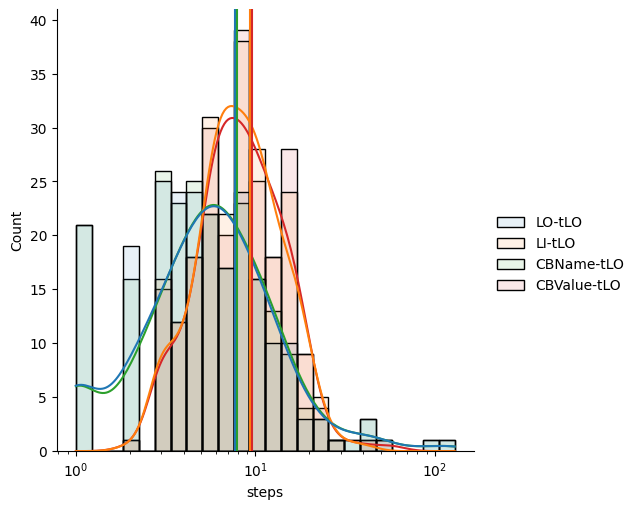

In [10]:
draw_steps_displot(data_to_draw={"LO-tLO": steps_LO_tLO,
                                 "LI-tLO": steps_LI_tLO,
                                 "CBName-tLO": steps_CBN_tLO,
                                 "CBValue-tLO": steps_CBV_tLO
                                 },
                   y_lines=(expected_values["LO-tLO"], expected_values["LI-tLO"], expected_values["CBN-tLO"], expected_values["CBV-tLO"]),
                   multiple="layer", element="bars", alpha=0.1)

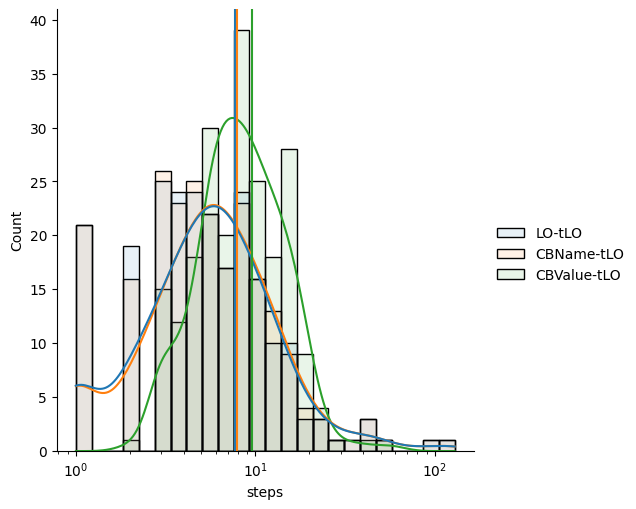

In [11]:
draw_steps_displot(data_to_draw={"LO-tLO": steps_LO_tLO,
                                 "CBName-tLO": steps_CBN_tLO,
                                 "CBValue-tLO": steps_CBV_tLO
                                 },
                   y_lines=(expected_values["LO-tLO"], expected_values["CBN-tLO"], expected_values["CBV-tLO"]),
                   multiple="layer", element="bars", alpha=0.1)

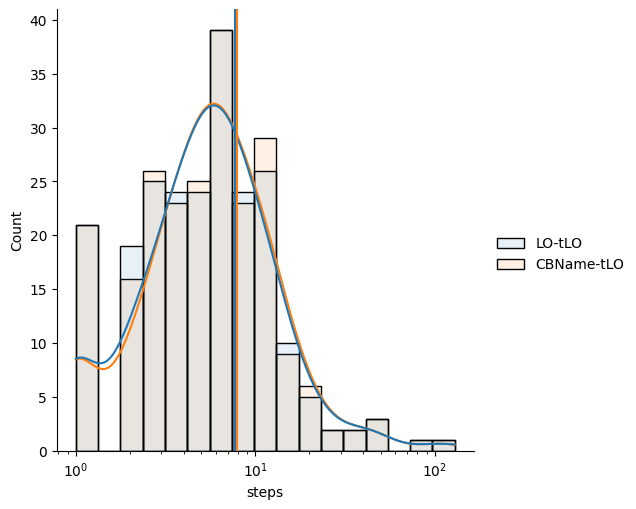

In [12]:
draw_steps_displot(data_to_draw={"LO-tLO": steps_LO_tLO,
                                 "CBName-tLO": steps_CBN_tLO,
                                 },
                   y_lines=(expected_values["LO-tLO"], expected_values["CBN-tLO"]),
                   multiple="layer", element="bars", alpha=0.1)

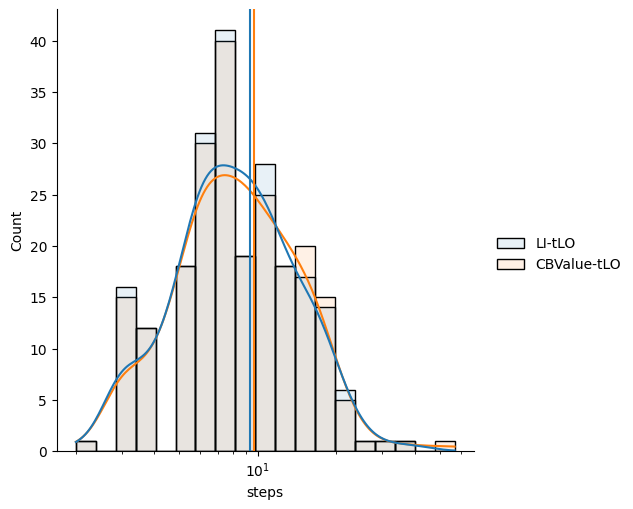

In [13]:
draw_steps_displot(data_to_draw={"LI-tLO": steps_LI_tLO,
                                 "CBValue-tLO": steps_CBV_tLO,
                                 },
                   y_lines=(expected_values["LI-tLO"], expected_values["CBV-tLO"]),
                   multiple="layer", element="bars", alpha=0.1)

# TEST ON RI-filtered terms

In [14]:
steps_LO_tRI = [normalize_term_time_limit(term, strategy_LO) for term in tqdm(terms_RI, desc="LO for t-RI")]
steps_LI_tRI = [normalize_term_time_limit(term, strategy_LI) for term in tqdm(terms_RI, desc="LI for t-RI")]
steps_CBV_tRI = [normalize_term_time_limit(term, strategy_CBV) for term in tqdm(terms_RI, desc="CBV for t-RI")]
steps_CBN_tRI = [normalize_term_time_limit(term, strategy_CBN) for term in tqdm(terms_RI, desc="CBN for t-RI")]

CBN for t-RI: 100%|██████████| 223/223 [01:03<00:00,  3.49it/s]


In [15]:
expected_values = dict()

expected_values["LO-tRI"] = get_expected_steps(steps_LO_tRI)
expected_values["LI-tRI"] = get_expected_steps(steps_LI_tRI)
expected_values["CBV-tRI"] = get_expected_steps(steps_CBV_tRI)
expected_values["CBN-tRI"] = get_expected_steps(steps_CBN_tRI)

Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 18.97it/s]


In [17]:
print(expected_values)

{'LO-tRI': 9.195662573884649, 'LI-tRI': 10.46004658948474, 'CBV-tRI': 10.906520475408135, 'CBN-tRI': 9.335312904113893}


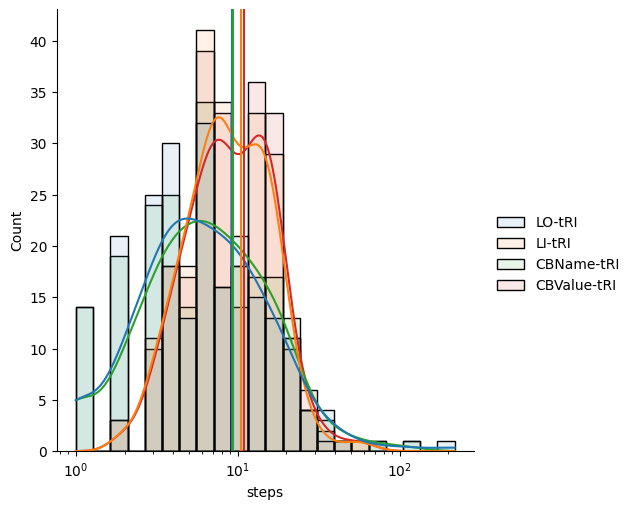

In [16]:
draw_steps_displot(data_to_draw={"LO-tRI": steps_LO_tRI,
                                 "LI-tRI": steps_LI_tRI,
                                 "CBName-tRI": steps_CBN_tRI,
                                 "CBValue-tRI": steps_CBV_tRI
                                 },
                   y_lines=(expected_values["LO-tRI"], expected_values["LI-tRI"], expected_values["CBN-tRI"], expected_values["CBV-tRI"]),
                   multiple="layer", element="bars", alpha=0.1)

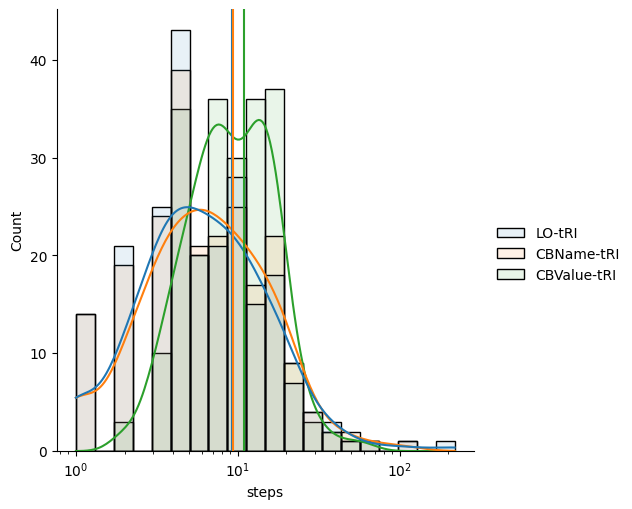

In [18]:
draw_steps_displot(data_to_draw={"LO-tRI": steps_LO_tRI,
                                 "CBName-tRI": steps_CBN_tRI,
                                 "CBValue-tRI": steps_CBV_tRI
                                 },
                   y_lines=(expected_values["LO-tRI"], expected_values["CBN-tRI"], expected_values["CBV-tRI"]),
                   multiple="layer", element="bars", alpha=0.1)

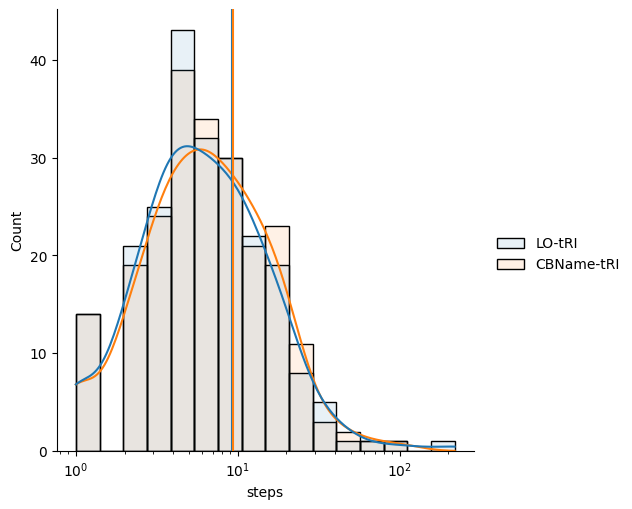

In [19]:
draw_steps_displot(data_to_draw={"LO-tRI": steps_LO_tRI,
                                 "CBName-tRI": steps_CBN_tRI,
                                 },
                   y_lines=(expected_values["LO-tRI"], expected_values["CBN-tRI"],),
                   multiple="layer", element="bars", alpha=0.1)

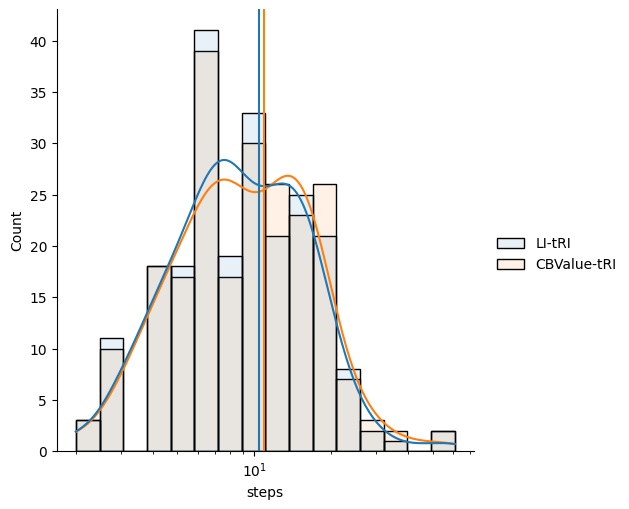

In [20]:
draw_steps_displot(data_to_draw={"LI-tRI": steps_LI_tRI,
                                 "CBValue-tRI": steps_CBV_tRI
                                 },
                   y_lines=(expected_values["LI-tRI"], expected_values["CBV-tRI"]),
                   multiple="layer", element="bars", alpha=0.1)